In [24]:
import keras
import pandas as pd
import tensorflow as tf

In [25]:
print("Keras version: ", keras.__version__)
print("Tensorflow version: ", tf.__version__)
print('GPUs available: ', tf.config.experimental.list_physical_devices('GPU'))

Keras version:  3.5.0
Tensorflow version:  2.17.0
GPUs available:  []


In [26]:
data_1 = pd.read_csv('mit-bih-data-clear-data.csv')
data_2 = pd.read_csv('ptb-diagnostic-clear-data.csv')
data_3 = pd.read_csv('autonomic-aging-a-dataset-clear-data.csv')


# Feature cleanup
df = pd.concat([data_1, data_2, data_3], ignore_index=True)
columns_to_drop = [
    'patient',
    'Max_hr_slope',
    'mean_deviation',
    'outliers_percentage'
]

columns_to_reduce = [
    'vlf_power',
    'lf_power',
    'hf_power',
    'highest_heart_rate',
    'lowest_heart_rate',
    'mean_heart_rate',
    'median_heart_rate'
]

df[columns_to_reduce] = df[columns_to_reduce].apply(lambda x: x/100)
df.drop(columns_to_drop, axis=1, inplace=True)

df.value_counts('diagnosis')


diagnosis
0    1162
1     487
Name: count, dtype: int64

In [27]:
# Take 50 samples of each class and remove them from the original dataframe

class_zero = df[df['diagnosis'] == 0].sample(50)
class_one = df[df['diagnosis'] == 1].sample(50)

df = df.drop(class_zero.index)
df = df.drop(class_one.index)

In [28]:
df.value_counts('diagnosis')

diagnosis
0    1112
1     437
Name: count, dtype: int64

In [29]:
class_zero.to_csv('virgin_class_zero.csv', index=False)
class_one.to_csv('virgin_class_one.csv', index=False)

In [30]:
# Let's check for missing values

df.isnull().sum()


diagnosis                      0
highest_heart_rate             0
lowest_heart_rate              0
mean_heart_rate                0
median_heart_rate              0
standard_deviation_hr          0
minimum_hrv                    0
maximum_hrv                    0
mean_hrv                       0
median_hrv                     0
standard_deviation_hrv         0
mean_hr_slope                  0
tendency_slope                 0
standard_deviation_hr_slope    0
vlf_power                      0
lf_power                       0
hf_power                       0
mean_rr                        0
standard_deviation_rr          0
minimum_rr                     0
maximum_rr                     0
tendency_standard_deviation    0
approximation_entropy          0
sample_entropy                 2
dtype: int64

In [31]:
# Replace missing and infinite values with median
from sklearn.impute import SimpleImputer
import numpy as np
df.replace([np.inf, -np.inf], np.nan, inplace=True)
imputer = SimpleImputer(strategy='median')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)


In [32]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']
X_resampled, y_resampled = smote.fit_resample(X, y)

df_upsampled = pd.concat([X_resampled, y_resampled], axis=1)




In [33]:
df_upsampled.value_counts('diagnosis')


diagnosis
0.0    1112
1.0    1112
Name: count, dtype: int64

In [34]:
# Uncomment to check Pairplot
# import seaborn as sns
# sns.set_theme(style='ticks')
# 
# sns.pairplot(df_upsampled, hue='diagnosis', kind='kde', corner=True)

/tmp/ipykernel_11993/3017331481.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.replace([np.inf, -np.inf], np.nan, inplace=True)


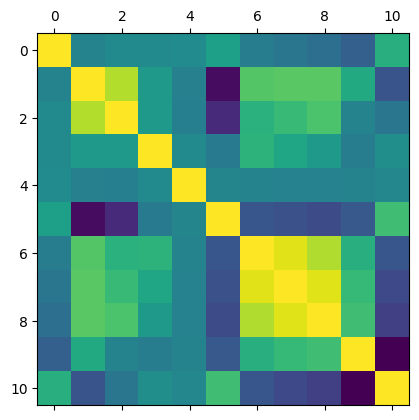

In [35]:
important_features = [
    'minimum_hrv',
    'maximum_hrv',
    'standard_deviation_hrv',
    'mean_hr_slope',
    'tendency_slope',
    'lowest_heart_rate',
    'vlf_power',
    'lf_power',
    'hf_power',
    'approximation_entropy'
]
from sklearn.impute import SimpleImputer
target = 'diagnosis'

features = df_upsampled[important_features]
features.replace([np.inf, -np.inf], np.nan, inplace=True)
imputer = SimpleImputer(strategy='median')

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = imputer.fit_transform(features)
features = scaler.fit_transform(features)
df = pd.DataFrame(features, columns=important_features)
df[target] = df_upsampled[target]

df.to_csv('heart_rate_final_data.csv', index=False)

import matplotlib.pyplot as plt
plt.matshow(df.corr())
plt.show()

In [36]:
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

X.head()

,minimum_hrv,maximum_hrv,standard_deviation_hrv,mean_hr_slope,tendency_slope,lowest_heart_rate,vlf_power,lf_power,hf_power,approximation_entropy
0,5.547082,-1.109145,-0.850964,-0.093745,-0.044844,4.146403,-0.282841,-0.189162,-0.243931,0.533203
1,3.443996,-0.784500,-0.742293,-0.078415,-0.043854,2.466885,0.477784,0.372857,-0.016356,0.270074
2,1.957010,-1.098415,-0.844264,-0.010445,-0.010987,1.182008,0.408632,-0.142781,-0.263094,0.151524
3,0.212703,-1.294043,-0.966522,-0.095353,0.008116,-0.939321,-0.121639,-0.414133,-0.484570,0.846870
4,0.539082,-0.826755,-0.696531,-0.017439,0.046582,-0.690242,1.140268,0.567355,-0.066972,0.534136


In [37]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [38]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=2, shuffle=True)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 0
Confusion Matrix:
 [[351  38]
 [  8 381]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.90      0.94       389
         1.0       0.91      0.98      0.94       389

    accuracy                           0.94       778
   macro avg       0.94      0.94      0.94       778
weighted avg       0.94      0.94      0.94       778



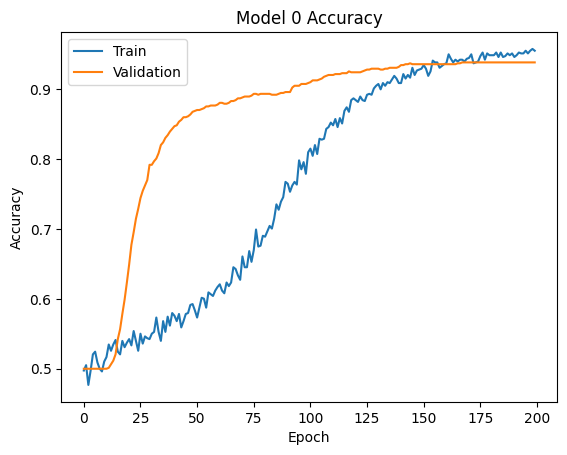

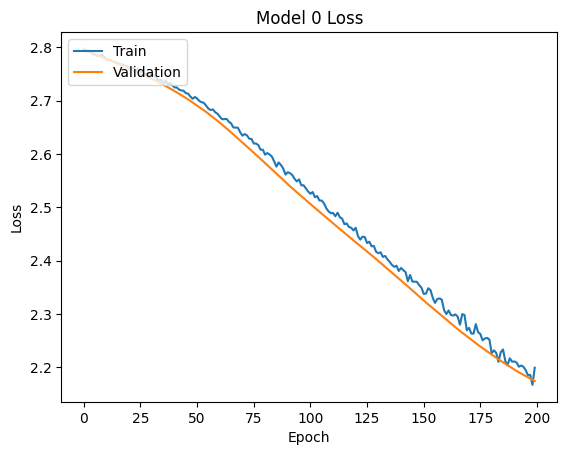

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 1
Confusion Matrix:
 [[359  30]
 [ 16 373]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.92      0.94       389
         1.0       0.93      0.96      0.94       389

    accuracy                           0.94       778
   macro avg       0.94      0.94      0.94       778
weighted avg       0.94      0.94      0.94       778



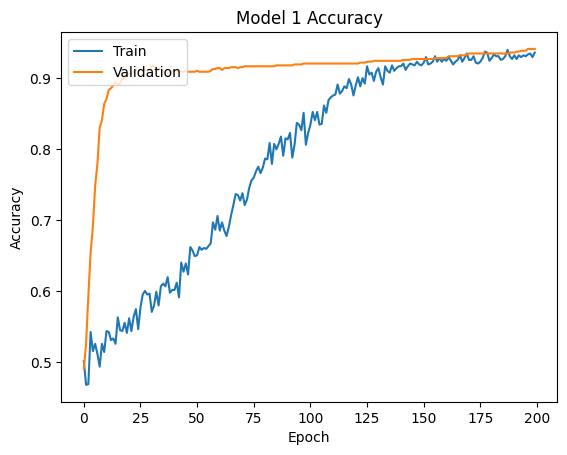

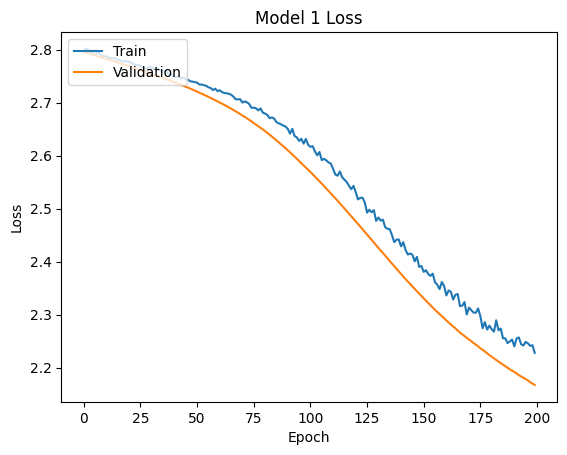

In [39]:
from keras import Sequential, Input
from keras.api.layers import Dense, Dropout
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.regularizers import l1, l2


accuracy_scores = []
i = 0
for train_index, test_index in skf.split(X_train, y_train):

    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    l1_regulizer = l1(0.0001)
    l2_regulizer = l2(0.0001)

    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(2048, activation='relu', kernel_regularizer=l1_regulizer),
        Dropout(0.5),
        Dense(1024, activation='relu', kernel_regularizer=l2_regulizer),
        Dropout(0.4),
        Dense(512, activation='relu', kernel_regularizer=l1_regulizer),
        Dropout(0.4),
        Dense(256, activation='relu', kernel_regularizer=l2_regulizer),
        Dropout(0.4),
        Dense(128, activation='relu', kernel_regularizer=l1_regulizer),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l2_regulizer),
        Dropout(0.2),
        Dense(32, activation='relu', kernel_regularizer=l1_regulizer),
        Dropout(0.1),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=keras.api.optimizers.Adam(learning_rate=0.000001), loss='binary_crossentropy', metrics=['accuracy'])

    from keras.api.callbacks import ModelCheckpoint, EarlyStopping
    checkpoint = ModelCheckpoint(f'model_{i}.keras', save_best_only=True)
    early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train_fold, y_train_fold, epochs=200, batch_size=8, verbose=0, callbacks=[checkpoint, early_stopping], validation_data=(X_test_fold, y_test_fold))

    # Evaluate the model
    y_pred = (model.predict(X_test_fold) > 0.6).astype("int32")
    accuracy = accuracy_score(y_test_fold, y_pred)
    accuracy_scores.append(accuracy)

    cm = confusion_matrix(y_test_fold, y_pred)
    cr = classification_report(y_test_fold, y_pred)
    print(f"Fold {i}")
    print("Confusion Matrix:\n", cm)
    print("\nClassification Report:\n", cr)


    import matplotlib.pyplot as plt

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model {i} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model {i} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()
    i += 1

In [40]:
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation of Accuracy: {std_accuracy:.4f}")


Mean Accuracy: 0.9409
Standard Deviation of Accuracy: 0.0000
